## Run this notebook

You can launch this notbook using mybinder, by clicking the button below.

<a href="https://mybinder.org/v2/gh/mccabete/fwiVis.git/NRT_notebook?labpath=NRT_notebook.ipynb">
<img src="https://mybinder.org/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> 
</a>

This notebook is an add-on to the NRT notebook. It contains a function to plot a state's history of active fires, aggregated by week. 

Imports: 

In [1]:
!pip install OWSLib==0.28.1 --quiet
!pip3 install contextily
!pip install geodatasets

In [2]:
from owslib.ogcapi.features import Features
import geopandas as gpd
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

%matplotlib inline

import contextily as cx
import geopandas
import rasterio
from rasterio.plot import show as rioshow
import matplotlib.pyplot as plt
from geodatasets import get_path
import matplotlib.patches as mpatches 
import numpy as np

import matplotlib as plt
import cartopy.crs as ccrs
import matplotlib

In [3]:
OGC_URL = "https://firenrt.delta-backend.com"

w = Features(url=OGC_URL)

In [4]:
perm = w.collection("public.eis_fire_snapshot_perimeter_nrt")

In [5]:
perm_q = w.collection_queryables("public.eis_fire_snapshot_perimeter_nrt")

Here, I created a function so you can look at any Western state's history of wildfires.

In [6]:
bounding_boxes = pd.read_csv("US_State_Bounding_Boxes.csv")
bounding_boxes = bounding_boxes[['NAME', 'xmin', 'ymin', 'xmax', 'ymax']]

In [7]:
state = 'Oregon'

state = input("What State would you like the bounding box coordinates for?")

In [75]:
import pandas as pd

def build_graph(state):
    
    import pandas as pd
    state_coordinates= bounding_boxes[bounding_boxes['NAME'] == state]
    state_coordinates = state_coordinates.values.tolist()
    state_coordinates = list(state_coordinates)
    state_coordinates = state_coordinates[0]
    state_coordinates = state_coordinates[1:5]
    new_state_coords = []
    for i in state_coordinates:
        i = f'{i}'
        new_state_coords.append(i)
    new_state_coords

    most_recent_time = max(*perm["extent"]["temporal"]["interval"])
    now = dt.datetime.strptime(most_recent_time, "%Y-%m-%dT%H:%M:%S+00:00")
# if you need to use a different region (CONUS or CA, you'll need to adjust these datetime objects)
    range2018 = ["2018-01-01T00:00:00+00:00/2018-12-31T00:00:00+00:00"]
    range2019 = ["2019-01-01T00:00:00+00:00/2019-12-31T00:00:00+00:00"]
    range2020 = ["2020-01-01T00:00:00+00:00/2020-12-31T00:00:00+00:00"]
    range2021 = ["2021-01-01T00:00:00+00:00/2021-12-31T00:00:00+00:00"]
    now = datetime.now().strftime('%Y-%m-%dT%H:%M:%S+00:00')
    range2024 = ["2024-01-01T00:00:00+00:00" + "/" + now]
    datetime_list = [range2018, range2019, range2020, range2021]

    def get_fire_perimeter_data(path, date_range, bbox):
        # Call the API or fetch data using the provided parameters
        year_results = w.collection_items(
            path,
            datetime=date_range,
            bbox=bbox,
            limit=9999
        )

        # Convert the fetched data to a GeoDataFrame
        year_df = gpd.GeoDataFrame.from_features(year_results["features"])

        year_df = year_df.set_crs("EPSG:4326")

        return year_df

    # Function to aggregate by week and count unique fireids
    def count_unique_fireids(df):
        df['week'] = df['t'].dt.isocalendar().week  # Get week number
        df = df[df['n_newpixels'] != 0]
        return df.groupby('week')['fireid'].nunique()
    
        # Function to aggregate by week and sum fire area
    def sum_fire_area(df):
        df['week'] = df['t'].dt.isocalendar().week  # Get week number
        return df.groupby('week')['farea'].sum()
    
    # Create a dictionary to store the results
    unique_counts_dict = {}
    farea_dict = {}

    # Example loop to fetch data and count unique fire IDs. Change layer if neeed. 
    for i, date_range in enumerate(datetime_list):
        df = get_fire_perimeter_data("public.eis_fire_lf_perimeter_archive", date_range, new_state_coords)
        df['t'] = pd.to_datetime(df['t'])
        unique_counts_df = count_unique_fireids(df)
        # Store in the dictionary with a key indicating the year or period
        unique_counts_dict[f'{i+2018}'] = unique_counts_df  # Assuming 2018 is the start year

        farea_df = sum_fire_area(df)
        farea_dict[f'{i+2018}'] = farea_df
        
    year2024df = get_fire_perimeter_data("public.eis_fire_lf_perimeter_nrt", range2024, new_state_coords)
    year2024df['t'] = pd.to_datetime(year2024df['t'])
    year2024df = year2024df[year2024df['n_newpixels'] != 0]
    unique_counts_04 = count_unique_fireids(year2024df)
    farea_dict['2024'] = sum_fire_area(year2024df)

    import matplotlib.pyplot as plt
    import pandas as pd

    plt.figure(figsize=(10, 6))
    plt.rcParams.update({'font.size': 12})
# Plot each year’s data from the dictionary
    for year, unique_counts in unique_counts_dict.items():
        plt.plot(unique_counts.index, unique_counts.values, label=year, marker='o', linestyle='-')
 
    plt.plot(unique_counts_04.index, unique_counts_04.values, label='2024', marker='o', linestyle='-')



    # If you'd like to highlight a portion of the graph (say the time of a specific fire, you can do that here)
    highlight_start = 27
    highlight_end = 29

    # Customize the x-axis ticks and labels
    week_intervals = range(1, 53)  # Assuming 52 weeks in a year
    week_labels = []

    # Calculate start and end dates for each week and format as month/day
    for week_num in week_intervals:
        start_date = pd.to_datetime(f'2023-01-01') + pd.DateOffset(weeks=week_num - 1)
        end_date = start_date + pd.DateOffset(days=6)
        week_label = f"{start_date.month}/{start_date.day}-{end_date.month}/{end_date.day}"
        week_labels.append(week_label)

    plt.xticks(week_intervals, week_labels, rotation=90, ha='right')  # Rotate labels for better visibilit

    # Get y limits of the plot
    y_min, y_max = plt.gca().get_ylim()

    # Create a polygon to fill the area
    highlight_polygon = np.array([[highlight_start, y_min], [highlight_start, y_max],
                                  [highlight_end, y_max], [highlight_end, y_min]])

    plt.fill(*highlight_polygon.T, color='yellow', alpha=0.3, label='Period of Falls Fire')

    # Customize the plot
    plt.title(f'Number of Large Active Fires per Week in {state}')
    plt.xlabel('Week of year')
    plt.ylabel('Number of Unique Fire IDs')
    plt.legend()
    plt.tight_layout()
    plt.show()

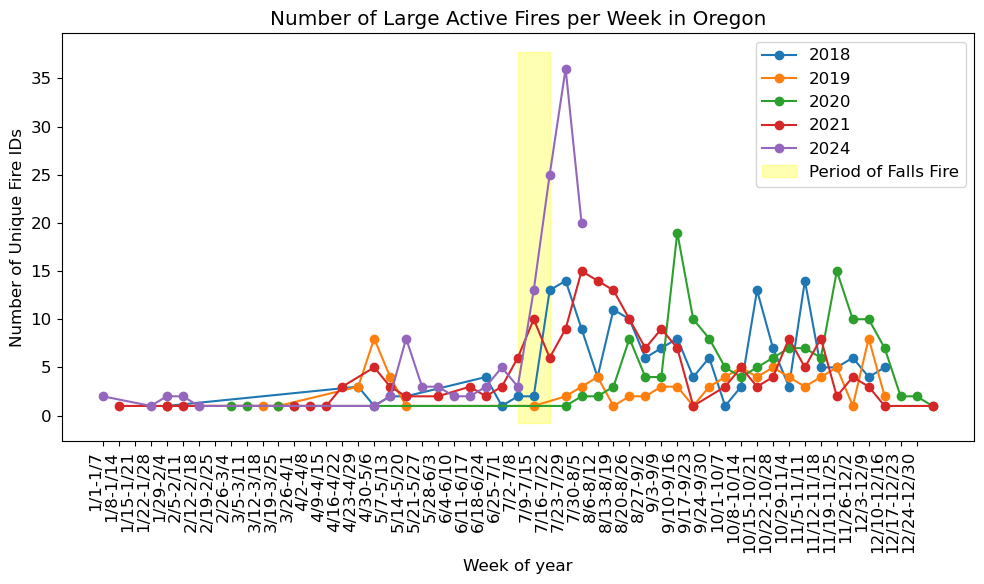

In [76]:
build_graph(state)

If you wanted an eastern state, you would need to specify a different path (ex: CONUS_NRT_DPS). 

Then, I wanted to see if I could create this not using the API but the files directly. To do that, I built csvs of 2021, 2022, 2023, and 2024 by modifying the load_file function from the FwiVis package. 

This would allow me to plot fires for the whole US since I wouldn't have the 10000 feature limit that the API query imposes. 

Now, you can read these csvs in when needed. 

In [6]:
year2022df = pd.read_csv('NEWyear2022df.csv')
year2023df = pd.read_csv('NEWyear2023df.csv')
year2024df = pd.read_csv('NEWyear2024df.csv')

You can then manipulate each df to remove any false positives. 

In [7]:


year2022df = year2022df[year2022df['farea'] >= 5]
year2022df = year2022df[year2022df['isactive'] == 1]
year2022df = year2022df[year2022df['n_newpixels'] != 0]
year2022df = year2022df[year2022df['ftype'].isin([2, 3, 4, 5])]

year2023df = year2023df[year2023df['farea'] >= 5]
year2023df = year2023df[year2023df['isactive'] == 1]
year2023df = year2023df[year2023df['n_newpixels'] != 0]
year2023df = year2023df[year2023df['ftype'].isin([2, 3, 4, 5])]

year2024df = year2024df[year2024df['farea'] >= 5]
year2024df = year2024df[year2024df['isactive'] == 1]
year2024df = year2024df[year2024df['n_newpixels'] != 0]
year2024df = year2024df[year2024df['ftype'].isin([2, 3, 4, 5])]


In [67]:
year2024df['t'] = pd.to_datetime(year2024df['t'])
year2023df['t'] = pd.to_datetime(year2023df['t'])
year2022df['t'] = pd.to_datetime(year2022df['t'])


start_date = '2023-09-01'
end_date = '2023-11-01'
# Create boolean mask for rows outside the specified time interval
mask = (year2023df['t'] < start_date) | (year2023df['t'] > end_date)

# Filter the dataframe based on the mask
year2023df = year2023df[mask]

# Function to aggregate by week and count unique fireids
def count_unique_fireids(df):
    df['week'] = df['t'].dt.isocalendar().week  # Get week number
    return df.groupby('week')['fireID'].nunique()

# Apply the function to each DataFrame
unique_counts_df1 = count_unique_fireids(year2024df)
unique_counts_df2 = count_unique_fireids(year2023df)
unique_counts_df3 = count_unique_fireids(year2022df)

week
1     6
2     7
3     9
4     7
5    29
Name: fireID, dtype: int64

In [68]:
import matplotlib.pyplot as plt

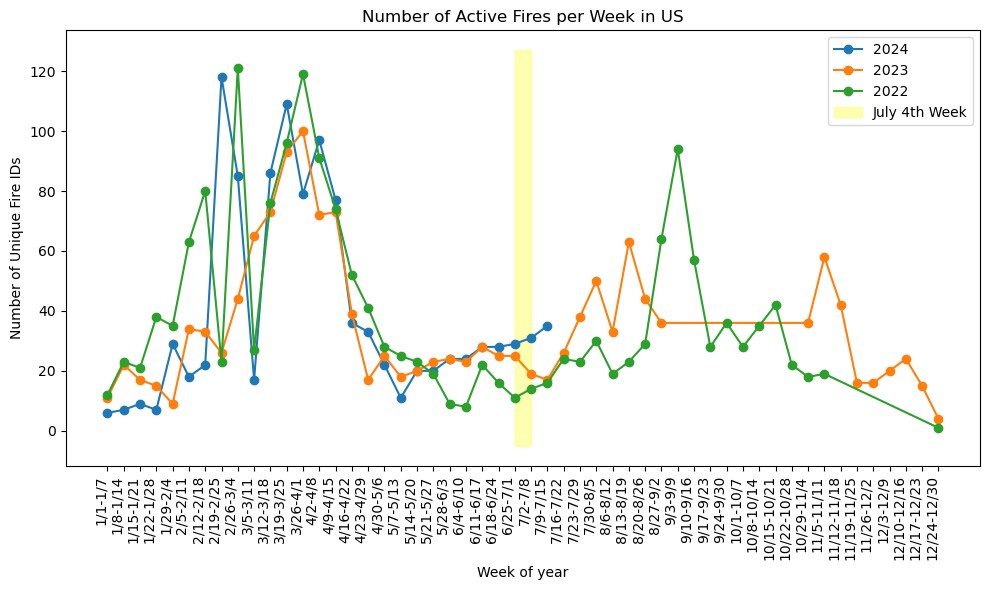

In [69]:
plt.figure(figsize=(10, 6))

# Plot unique fireid counts for each DataFrame
plt.plot(unique_counts_df1.index, unique_counts_df1.values, label='2024', marker='o', linestyle='-')
plt.plot(unique_counts_df2.index, unique_counts_df2.values, label='2023', marker='o', linestyle='-')
plt.plot(unique_counts_df3.index, unique_counts_df3.values, label='2022', marker='o', linestyle='-')


# Highlighting weeks 26-28
highlight_start = 26
highlight_end = 27

# Customize the x-axis ticks and labels
week_intervals = range(1, 53)  # Assuming 52 weeks in a year
week_labels = []

# Calculate start and end dates for each week and format as month/day
for week_num in week_intervals:
    start_date = pd.to_datetime(f'2023-01-01') + pd.DateOffset(weeks=week_num - 1)
    end_date = start_date + pd.DateOffset(days=6)
    week_label = f"{start_date.month}/{start_date.day}-{end_date.month}/{end_date.day}"
    week_labels.append(week_label)

plt.xticks(week_intervals, week_labels, rotation=90, ha='right')  # Rotate labels for better visibilit

# Get y limits of the plot
y_min, y_max = plt.gca().get_ylim()

# Create a polygon to fill the area
highlight_polygon = np.array([[highlight_start, y_min], [highlight_start, y_max],
                              [highlight_end, y_max], [highlight_end, y_min]])

plt.fill(*highlight_polygon.T, color='yellow', alpha=0.3, label='July 4th Week')

# Customize the plot
plt.title('Number of Active Fires per Week in US')
plt.xlabel('Week of year')
plt.ylabel('Number of Unique Fire IDs')
plt.legend()
plt.tight_layout()
plt.show()